In [1]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp

import tensorflow as tf
import keras_core as keras
import keras_nlp

Using TensorFlow backend


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt


In [3]:
pwd

'/Users/sumitsoni/Documents/git_repo/ml_project/DetectAIGeneratedText'

In [5]:
# directory = '/Users/sumitsoni/Documents/git_repo/ml_project/DetectAIGeneratedText'

# for dirname, _, filenames in os.walk(directory):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# #         filename=pd.read_csv(os.path.join(dirname, filename))

In [6]:
train_essays=pd.read_csv(directory+'/llm-detect-ai-generated-text/train_essays.csv')
test_essays=pd.read_csv(directory+'/llm-detect-ai-generated-text/test_essays.csv')
train_prompts=pd.read_csv(directory+'/llm-detect-ai-generated-text/train_prompts.csv')
sample_submissions=pd.read_csv(directory+'/llm-detect-ai-generated-text/sample_submission.csv')

In [7]:
print(train_essays.info())
train_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


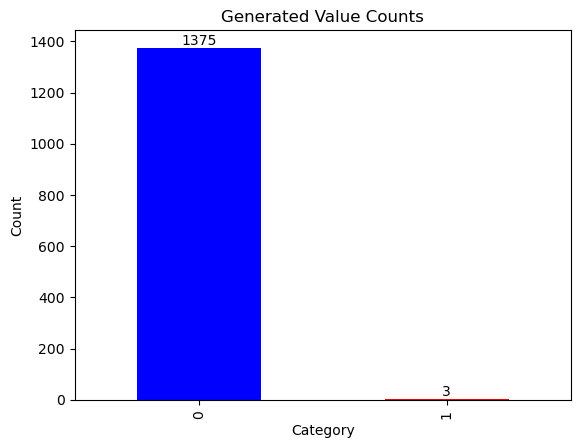

In [8]:

value_counts=train_essays['generated'].value_counts()
value_counts.plot(kind='bar',color = ['blue', 'red'])
plt.title('Generated Value Counts')
plt.xlabel('Category')
plt.ylabel('Count')
for i, value in enumerate(value_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

In [9]:
#Above dataset in imbalance, Adding already created datset

added_train_data=pd.read_csv(directory+'/train_v2_drcat_02.csv')

In [10]:
print(added_train_data.info())
added_train_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB
None


,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False


In [11]:
added_train_data.rename(columns={'label':'generated'},inplace=True)

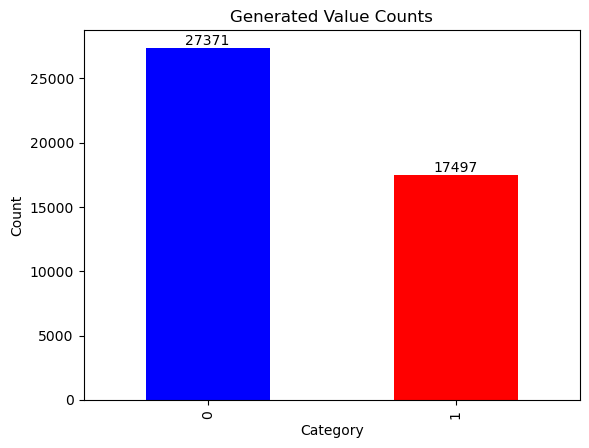

In [12]:
value_counts=added_train_data['generated'].value_counts()
value_counts.plot(kind='bar',color = ['blue', 'red'])
plt.title('Generated Value Counts')
plt.xlabel('Category')
plt.ylabel('Count')
for i, value in enumerate(value_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()

In [13]:
added_train_data.head(2)

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False


In [14]:
train_data_all=pd.concat((train_essays[['text','generated']],added_train_data[['text','generated']]),axis=0)
train_data_all.head(2)

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0


In [15]:
print(train_data_all.info())
train_data_all.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46246 entries, 0 to 44867
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46246 non-null  object
 1   generated  46246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None


,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0


In [16]:
train_data_all['text_len']=train_data_all.apply(lambda row: len(row['text']),axis=1)
train_data_all['text_words_count']=train_data_all.apply(lambda row: len(row['text'].split()),axis=1)

In [17]:
train_data_all.head()

,text,generated,text_len,text_words_count
0,Cars. Cars have been around since they became ...,0,3289,584
1,Transportation is a large necessity in most co...,0,2738,462
2,"""America's love affair with it's vehicles seem...",0,4428,744
3,How often do you ride in a car? Do you drive a...,0,4013,686
4,Cars are a wonderful thing. They are perhaps o...,0,4698,871


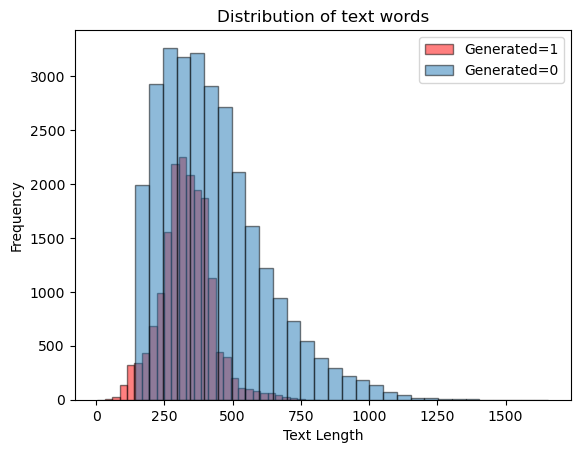

In [18]:
plt.hist(train_data_all[train_data_all['generated']==1]['text_words_count'],color='red', bins=30, alpha=0.5, label='Generated=1', edgecolor='black')
plt.hist(train_data_all[train_data_all['generated'] == 0]['text_words_count'], bins=30, alpha=0.5, label='Generated=0', edgecolor='black')

plt.title('Distribution of text words')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')  # Add a legend to differentiate between the two histograms

plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm

# Load your dataset
# Assuming your dataset is in a CSV file with columns 'text' and 'ai_generated_flag'
# Modify the file path accordingly

# Split the dataset into training and testing sets
df=train_data_all
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenize and prepare the input data
def prepare_data(df, tokenizer, max_length=128):
    tokenized = tokenizer(list(df['text']), max_length=max_length, padding=True, truncation=True, return_tensors='pt')
    labels = torch.tensor(df['generated'].tolist())
    return tokenized, labels

train_data, train_labels = prepare_data(train_df, tokenizer)
test_data, test_labels = prepare_data(test_df, tokenizer)

# Create DataLoader for training and testing
train_dataset = TensorDataset(train_data['input_ids'], train_data['attention_mask'], train_labels)
test_dataset = TensorDataset(test_data['input_ids'], test_data['attention_mask'], test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training parameters
epochs = 3
lr = 1e-5

optimizer = AdamW(model.parameters(), lr=lr)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        inputs = {key: val.to(device) for key, val in zip(['input_ids', 'attention_mask'], batch[:2])}
        labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Evaluating'):
        inputs = {key: val.to(device) for key, val in zip(['input_ids', 'attention_mask'], batch[:2])}
        labels = batch[2].to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
classification_report_str = classification_report(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report_str)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi